<a href="https://colab.research.google.com/github/The20thDuck/Neuro-140-Project/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
!pip install transformers
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTConfig
from PIL import Image
import requests


In [2]:

url = 'https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog10.png'
image = Image.open(requests.get(url, stream=True).raw)
feature_extractor = ViTFeatureExtractor.from_pretrained('nateraw/vit-base-patch16-224-cifar10')
model = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10')
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
preds = outputs.logits.argmax(dim=1)

classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]
classes[preds[0]]

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/918 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/327M [00:00<?, ?B/s]

'dog'

In [3]:
import matplotlib.pyplot as plt
import torch as t
# !pip install pytorch-model-summary

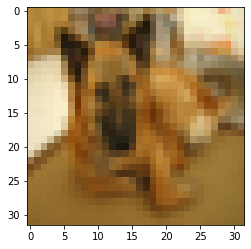

In [4]:
plt.imshow(image)

In [6]:
!pip install pytorch-model-summary
from pytorch_model_summary import summary
print(inputs.keys())
summary(model, inputs.pixel_values, show_input=True)

dict_keys(['pixel_values'])


'------------------------------------------------------------------------\n      Layer (type)          Input Shape         Param #     Tr. Param #\n========================================================================\n        ViTModel-1     [1, 3, 224, 224]      85,798,656      85,798,656\n          Linear-2             [1, 768]           7,690           7,690\n========================================================================\nTotal params: 85,806,346\nTrainable params: 85,806,346\nNon-trainable params: 0\n------------------------------------------------------------------------'

In [7]:
inputs.pixel_values.shape

torch.Size([1, 3, 224, 224])

In [9]:
import itertools
!pip install einops
import einops
import torchsummary
import pytorch_model_summary



In [ ]:
model

In [57]:
# patch embedding

class PatchEmbedding(t.nn.Module):
  def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, imgsize=224):
    super().__init__()
    self.cls_token = t.nn.Parameter(t.randn(1, 1, emb_size)) # b, n, emb_size. Add to the list of module params
    self.n = (imgsize//patch_size)**2
    self.emb_size = emb_size
    self.position_embeddings = t.nn.Parameter(t.randn(1, self.n + 1, emb_size)) # +1 for cls
    self.projection = t.nn.Conv2d(in_channels, emb_size, patch_size, patch_size, 0)

  def forward(self, inputs):
    token_embeddings = einops.rearrange(self.projection(inputs), 'b c h w -> b (h w) c')
    b = inputs.shape[0]
    cls_embeddings = self.cls_token.repeat((b, 1, 1))
    return t.cat((cls_embeddings, token_embeddings), dim = 1) + self.position_embeddings

patch_embed = PatchEmbedding()

pytorch_model_summary.summary(patch_embed, t.randn(1, 3, 224, 224), show_input=True)


'------------------------------------------------------------------------\n      Layer (type)          Input Shape         Param #     Tr. Param #\n========================================================================\n          Conv2d-1     [1, 3, 224, 224]         590,592         590,592\n========================================================================\nTotal params: 590,592\nTrainable params: 590,592\nNon-trainable params: 0\n------------------------------------------------------------------------'

In [17]:

pytorch_model_summary.summary(model.vit.embeddings, t.randn(1, 3, 224, 224), show_input=True)


'--------------------------------------------------------------------------\n        Layer (type)          Input Shape         Param #     Tr. Param #\n==========================================================================\n   PatchEmbeddings-1     [1, 3, 224, 224]         590,592         590,592\n           Dropout-2        [1, 197, 768]               0               0\n==========================================================================\nTotal params: 590,592\nTrainable params: 590,592\nNon-trainable params: 0\n--------------------------------------------------------------------------'

In [18]:
# load params

print(model.vit.embeddings.state_dict().keys())
print(patch_embed.state_dict().keys())
mapped_params = {k: v for (k, v) in zip(patch_embed.state_dict().keys(), model.vit.embeddings.state_dict().values())}
patch_embed.load_state_dict(mapped_params)

patch_embed(inputs.pixel_values) == model.vit.embeddings(inputs.pixel_values)

odict_keys(['cls_token', 'position_embeddings', 'patch_embeddings.projection.weight', 'patch_embeddings.projection.bias'])
odict_keys(['cls_token', 'position_embeddings', 'projection.weight', 'projection.bias'])


tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]])

In [ ]:
e = t.nn.TransformerEncoderLayer(768, nhead=12, dim_feedforward=768*4, activation="gelu",norm_first=True,batch_first=True, dropout=0., layer_norm_eps=1e-12)
x = e.state_dict().keys()
y = model.vit.encoder.layer[0].state_dict().keys()
print(len(x), len(y))
for m1, m2 in itertools.zip_longest(x, y):
  # print (None if not m1 else m1[1].shape, m2[1].shape)
  print(f'{str(m1):30}{m2}')

In [21]:
import re
def getval(key, state_dict):
  key = re.sub('linear1', "intermediate.dense", key)
  key = re.sub('linear2', "output.dense", key)
  key = re.sub('norm1', "layernorm_before", key)
  key = re.sub('norm2', "layernorm_before", key)
  key = re.sub('self_attn', 'attention', key)
  key = re.sub('in_proj_', 'attention.', key)
  key = re.sub('out_proj', 'output.dense', key)
  if "attention.attention" in key:
    for end in [".weight", ".bias"]:
      if end in key:
        keys = [("attention.attention." + x + end) for x in ["query", "key", "value"]]
        return t.cat([state_dict[k] for k in keys], dim=0)
  else:
    return state_dict[key]
mapped_dict = {k: getval(k, model.vit.encoder.layer[0].state_dict()) for k in e.state_dict().keys()}
e.load_state_dict(mapped_dict)

<All keys matched successfully>

In [ ]:
z = t.randn(1, 16*16+1, 768).cuda()
e.cuda()
model.cuda()
e(z) - model.vit.encoder.layer[0](z)[0]

In [121]:
class ClassificationHead(t.nn.Module):
  def __init__(self, num_classes, emb_size):
    super().__init__()
    self.ln = t.nn.LayerNorm((emb_size,), eps = 1e-12)
    self.layer = t.nn.Linear(emb_size, num_classes)

  def forward(self, x):
    return self.layer(self.ln(x)[:,0,:])


class ViT_New(t.nn.Module):
  def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, nhead=12, imgsize=224, num_classes=10, L = 6, from_hugging = False):
    super().__init__()
    self.patch_emb = PatchEmbedding(in_channels, patch_size, emb_size, imgsize)
    self.from_hugging = from_hugging
    if from_hugging:
      config = ViTConfig(hidden_size=emb_size, num_hidden_layers = L, num_attention_heads = nhead, intermediate_size=emb_size*4, patch_size=patch_size, image_size=imgsize, encoder_stride=patch_size)
      self.encoder = ViTForImageClassification(config).vit.encoder
    else:
      self.encoder = t.nn.Sequential(*[
        t.nn.TransformerEncoderLayer(
          emb_size,
          nhead=nhead, 
          dim_feedforward=emb_size*4, 
          activation="gelu",
          norm_first=True,
          batch_first=True, 
          dropout=0., 
          layer_norm_eps=1e-12
        ) for _ in range(L)])
    self.classifier = ClassificationHead(num_classes, emb_size=emb_size)

  def forward(self, x):
    emb = self.patch_emb(x)
    encoding = self.encoder(emb)
    if self.from_hugging:
      encoding = encoding.last_hidden_state
    return self.classifier(encoding)

  def init_from_pretrained(self, model):
    mapped_params = {k: v for (k, v) in zip(self.patch_emb.state_dict().keys(), model.vit.embeddings.state_dict().values())}
    self.patch_emb.load_state_dict(mapped_params)

    self.encoder.load_state_dict(model.vit.encoder.state_dict())
    self.classifier.ln.load_state_dict(model.vit.layernorm.state_dict())
    self.classifier.layer.load_state_dict(model.classifier.state_dict())
    


In [128]:
vit = ViT_New(emb_size = 96, nhead=4, imgsize=32, patch_size=4, num_classes=10)
vit(t.randn(1, 3, 32, 32))

tensor([[-0.2278,  0.1822,  0.1573,  0.2253, -0.2574,  0.7107,  0.0899, -0.4623,
          0.6700, -0.0561]], grad_fn=<AddmmBackward0>)

In [56]:
# vit.init_from_pretrained(model)
# vit(z)

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]])


tensor([[-0.5499,  0.1384, -0.1996,  0.7755, -0.0542,  0.7350,  0.1657, -0.8578,
         -0.0503,  0.1252]], grad_fn=<AddmmBackward0>)

SequenceClassifierOutput([('logits',
                           tensor([[-0.5499,  0.1384, -0.1996,  0.7755, -0.0542,  0.7350,  0.1657, -0.8578,
                                    -0.0503,  0.1252]], device='cuda:0', grad_fn=<AddmmBackward0>))])

In [78]:
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [82]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [84]:
getloader = lambda x: DataLoader(x, batch_size = batch_size, shuffle=True, num_workers=2)
train_loader = getloader(trainset)
test_loader = getloader(testset)

In [133]:
optimizer = t.optim.Adam(vit.parameters(), weight_decay=0.)
num_epochs = 5

criterion = t.nn.functional.cross_entropy

In [93]:
pytorch_model_summary.summary(vit, t.zeros(1, 3, 32, 32), show_input=True)

'---------------------------------------------------------------------------------\n                Layer (type)         Input Shape         Param #     Tr. Param #\n=================================================================================\n            PatchEmbedding-1      [1, 3, 32, 32]          52,032          52,032\n   TransformerEncoderLayer-2       [1, 257, 192]         444,864         444,864\n        ClassificationHead-3       [1, 257, 192]           2,314           2,314\n=================================================================================\nTotal params: 499,210\nTrainable params: 499,210\nNon-trainable params: 0\n---------------------------------------------------------------------------------'

In [134]:
losses = []

def calc_accuracy(model):
  accuracies = []
  for step, (x, y) in enumerate(tqdm(test_loader)):
    model.eval()
    with t.no_grad():
      logits = vit(x)
      accuracy = (t.argmax(logits, dim=-1) == y).float().mean().item()
      if step % 10 == 0:
        print(accuracy)
      accuracies.append(accuracy)
  return t.Tensor(accuracies).mean().item()

losses = []
accuracies = []
for epoch in range(num_epochs):

  print(calc_accuracy(vit))
  model.train()
  for step, (x, y) in enumerate(tqdm(train_loader)):
    vit.zero_grad()
    logits = vit(x)
    loss = criterion(logits, y)
    loss.backward()
    losses.append(loss.item())
    accuracies.append((t.argmax(logits, dim=-1)==y).float().mean().item())
    optimizer.step()
    if step % 10 == 0:
      print(f'loss: {t.Tensor(losses[-10:]).mean()}, acc: {t.Tensor(accuracies[-10:]).mean()}')

print(calc_accuracy(vit))




  1%|▏         | 1/79 [00:00<00:56,  1.38it/s]

0.5234375


 14%|█▍        | 11/79 [00:05<00:29,  2.34it/s]

0.546875


 27%|██▋       | 21/79 [00:09<00:23,  2.47it/s]

0.5625


 39%|███▉      | 31/79 [00:13<00:20,  2.39it/s]

0.546875


 52%|█████▏    | 41/79 [00:17<00:15,  2.50it/s]

0.5078125


 65%|██████▍   | 51/79 [00:21<00:11,  2.42it/s]

0.53125


 77%|███████▋  | 61/79 [00:25<00:07,  2.48it/s]

0.53125


 90%|████████▉ | 71/79 [00:29<00:03,  2.50it/s]

0.609375


100%|██████████| 79/79 [00:32<00:00,  2.42it/s]


0.5572587251663208


  0%|          | 1/391 [00:02<13:56,  2.15s/it]

loss: 1.1149942874908447, acc: 0.609375


  3%|▎         | 11/391 [00:17<09:40,  1.53s/it]

loss: 1.2348158359527588, acc: 0.559374988079071


  5%|▌         | 21/391 [00:32<09:29,  1.54s/it]

loss: 1.2034648656845093, acc: 0.567187488079071


  8%|▊         | 31/391 [00:47<09:07,  1.52s/it]

loss: 1.2059861421585083, acc: 0.561718761920929


 10%|█         | 41/391 [01:03<08:55,  1.53s/it]

loss: 1.1261366605758667, acc: 0.5921875238418579


 13%|█▎        | 51/391 [01:18<08:42,  1.54s/it]

loss: 1.178804636001587, acc: 0.585156261920929


 16%|█▌        | 61/391 [01:33<08:19,  1.51s/it]

loss: 1.1911035776138306, acc: 0.5726562738418579


 18%|█▊        | 71/391 [01:49<08:11,  1.54s/it]

loss: 1.187943696975708, acc: 0.565625011920929


 21%|██        | 81/391 [02:04<07:56,  1.54s/it]

loss: 1.1816478967666626, acc: 0.5765625238418579


 23%|██▎       | 91/391 [02:19<07:42,  1.54s/it]

loss: 1.1265453100204468, acc: 0.598437488079071


 26%|██▌       | 101/391 [02:35<07:20,  1.52s/it]

loss: 1.159624457359314, acc: 0.596875011920929


 28%|██▊       | 111/391 [02:50<07:06,  1.52s/it]

loss: 1.2235028743743896, acc: 0.550000011920929


 31%|███       | 121/391 [03:05<06:57,  1.55s/it]

loss: 1.1898070573806763, acc: 0.578906238079071


 34%|███▎      | 131/391 [03:21<06:40,  1.54s/it]

loss: 1.2079970836639404, acc: 0.573437511920929


 36%|███▌      | 141/391 [03:36<06:17,  1.51s/it]

loss: 1.1444202661514282, acc: 0.585156261920929


 39%|███▊      | 151/391 [03:51<06:03,  1.51s/it]

loss: 1.179379940032959, acc: 0.5835937261581421


 41%|████      | 161/391 [04:06<05:48,  1.52s/it]

loss: 1.14923894405365, acc: 0.594531238079071


 44%|████▎     | 171/391 [04:22<05:37,  1.53s/it]

loss: 1.1603453159332275, acc: 0.585156261920929


 46%|████▋     | 181/391 [04:37<05:18,  1.52s/it]

loss: 1.2028594017028809, acc: 0.578906238079071


 49%|████▉     | 191/391 [04:52<05:03,  1.52s/it]

loss: 1.177700400352478, acc: 0.578125


 51%|█████▏    | 201/391 [05:08<04:48,  1.52s/it]

loss: 1.1887133121490479, acc: 0.5726562738418579


 54%|█████▍    | 211/391 [05:23<04:39,  1.55s/it]

loss: 1.1706717014312744, acc: 0.577343761920929


 57%|█████▋    | 221/391 [05:38<04:19,  1.53s/it]

loss: 1.1808428764343262, acc: 0.5843750238418579


 59%|█████▉    | 231/391 [05:53<04:05,  1.54s/it]

loss: 1.1556929349899292, acc: 0.598437488079071


 62%|██████▏   | 241/391 [06:09<03:51,  1.55s/it]

loss: 1.1424719095230103, acc: 0.577343761920929


 64%|██████▍   | 251/391 [06:24<03:37,  1.55s/it]

loss: 1.1633059978485107, acc: 0.594531238079071


 67%|██████▋   | 261/391 [06:40<03:21,  1.55s/it]

loss: 1.1633379459381104, acc: 0.5882812738418579


 69%|██████▉   | 271/391 [06:55<03:02,  1.52s/it]

loss: 1.1316090822219849, acc: 0.612500011920929


 72%|███████▏  | 281/391 [07:10<02:48,  1.53s/it]

loss: 1.1830075979232788, acc: 0.578125


 74%|███████▍  | 291/391 [07:26<02:33,  1.54s/it]

loss: 1.165570855140686, acc: 0.582812488079071


 77%|███████▋  | 301/391 [07:41<02:19,  1.55s/it]

loss: 1.1831016540527344, acc: 0.573437511920929


 80%|███████▉  | 311/391 [07:57<02:02,  1.53s/it]

loss: 1.1523183584213257, acc: 0.586718738079071


 82%|████████▏ | 321/391 [08:12<01:46,  1.52s/it]

loss: 1.1705684661865234, acc: 0.5804687738418579


 85%|████████▍ | 331/391 [08:27<01:31,  1.52s/it]

loss: 1.1810320615768433, acc: 0.590624988079071


 87%|████████▋ | 341/391 [08:42<01:17,  1.54s/it]

loss: 1.138184666633606, acc: 0.57421875


 90%|████████▉ | 351/391 [08:58<01:01,  1.53s/it]

loss: 1.1071126461029053, acc: 0.5921875238418579


 92%|█████████▏| 361/391 [09:13<00:45,  1.53s/it]

loss: 1.186887502670288, acc: 0.5804687738418579


 95%|█████████▍| 371/391 [09:28<00:30,  1.51s/it]

loss: 1.166648030281067, acc: 0.592968761920929


 97%|█████████▋| 381/391 [09:43<00:15,  1.51s/it]

loss: 1.180587887763977, acc: 0.5843750238418579


100%|██████████| 391/391 [09:58<00:00,  1.53s/it]


loss: 1.1417512893676758, acc: 0.5818749666213989


  1%|▏         | 1/79 [00:00<00:57,  1.37it/s]

0.625


 14%|█▍        | 11/79 [00:04<00:27,  2.45it/s]

0.625


 27%|██▋       | 21/79 [00:08<00:22,  2.53it/s]

0.5546875


 39%|███▉      | 31/79 [00:12<00:18,  2.54it/s]

0.5703125


 52%|█████▏    | 41/79 [00:16<00:15,  2.49it/s]

0.6328125


 65%|██████▍   | 51/79 [00:20<00:11,  2.43it/s]

0.5546875


 77%|███████▋  | 61/79 [00:24<00:07,  2.44it/s]

0.5703125


 90%|████████▉ | 71/79 [00:28<00:03,  2.55it/s]

0.5703125


100%|██████████| 79/79 [00:31<00:00,  2.49it/s]


0.5712025165557861


  0%|          | 1/391 [00:02<13:54,  2.14s/it]

loss: 1.1570583581924438, acc: 0.5764062404632568


  3%|▎         | 11/391 [00:17<09:41,  1.53s/it]

loss: 1.110277771949768, acc: 0.6148437261581421


  5%|▌         | 21/391 [00:32<09:18,  1.51s/it]

loss: 1.1148135662078857, acc: 0.594531238079071


  8%|▊         | 31/391 [00:48<09:18,  1.55s/it]

loss: 1.0728307962417603, acc: 0.633593738079071


 10%|█         | 41/391 [01:03<08:58,  1.54s/it]

loss: 1.1060798168182373, acc: 0.6117187738418579


 13%|█▎        | 51/391 [01:19<08:36,  1.52s/it]

loss: 1.0735636949539185, acc: 0.620312511920929


 16%|█▌        | 61/391 [01:34<08:33,  1.55s/it]

loss: 1.0408341884613037, acc: 0.6382812261581421


 18%|█▊        | 71/391 [01:50<08:57,  1.68s/it]

loss: 1.063984990119934, acc: 0.609375


 21%|██        | 81/391 [02:06<08:11,  1.59s/it]

loss: 1.1195051670074463, acc: 0.5992187261581421


 23%|██▎       | 91/391 [02:22<08:05,  1.62s/it]

loss: 1.1059577465057373, acc: 0.6070312261581421


 26%|██▌       | 101/391 [02:37<07:27,  1.54s/it]

loss: 1.0525410175323486, acc: 0.6265624761581421


 28%|██▊       | 111/391 [02:53<07:14,  1.55s/it]

loss: 1.1063425540924072, acc: 0.625


 31%|███       | 121/391 [03:08<07:00,  1.56s/it]

loss: 1.105952501296997, acc: 0.5992187261581421


 34%|███▎      | 131/391 [03:24<07:06,  1.64s/it]

loss: 1.1419659852981567, acc: 0.5843750238418579


 36%|███▌      | 141/391 [03:40<06:34,  1.58s/it]

loss: 1.112180471420288, acc: 0.600781261920929


 39%|███▊      | 151/391 [03:56<06:21,  1.59s/it]

loss: 1.0672290325164795, acc: 0.6343749761581421


 41%|████      | 161/391 [04:12<05:58,  1.56s/it]

loss: 1.118449330329895, acc: 0.59375


 44%|████▎     | 171/391 [04:27<05:35,  1.53s/it]

loss: 1.1409019231796265, acc: 0.589062511920929


 46%|████▋     | 181/391 [04:43<05:27,  1.56s/it]

loss: 1.1604986190795898, acc: 0.5874999761581421


 49%|████▉     | 191/391 [04:58<05:11,  1.56s/it]

loss: 1.0815138816833496, acc: 0.606249988079071


 51%|█████▏    | 201/391 [05:14<04:53,  1.54s/it]

loss: 1.0883843898773193, acc: 0.586718738079071


 54%|█████▍    | 211/391 [05:29<04:36,  1.54s/it]

loss: 1.0419753789901733, acc: 0.62890625


 57%|█████▋    | 221/391 [05:45<04:20,  1.53s/it]

loss: 1.101741075515747, acc: 0.6031249761581421


 59%|█████▉    | 231/391 [06:00<04:05,  1.53s/it]

loss: 1.0720970630645752, acc: 0.6195312738418579


 62%|██████▏   | 241/391 [06:16<03:51,  1.54s/it]

loss: 1.1047275066375732, acc: 0.600781261920929


 64%|██████▍   | 251/391 [06:31<03:36,  1.55s/it]

loss: 1.1137166023254395, acc: 0.6171875


 67%|██████▋   | 261/391 [06:47<03:25,  1.58s/it]

loss: 1.0995129346847534, acc: 0.616406261920929


 69%|██████▉   | 271/391 [07:02<03:05,  1.55s/it]

loss: 1.0752432346343994, acc: 0.6234375238418579


 72%|███████▏  | 281/391 [07:18<02:50,  1.55s/it]

loss: 1.106149435043335, acc: 0.604687511920929


 74%|███████▍  | 291/391 [07:33<02:38,  1.58s/it]

loss: 1.0740314722061157, acc: 0.6148437261581421


 77%|███████▋  | 301/391 [07:49<02:19,  1.55s/it]

loss: 1.0634838342666626, acc: 0.6117187738418579


 80%|███████▉  | 311/391 [08:05<02:05,  1.57s/it]

loss: 1.1153661012649536, acc: 0.585156261920929


 82%|████████▏ | 321/391 [08:21<01:49,  1.56s/it]

loss: 1.1473785638809204, acc: 0.58984375


 85%|████████▍ | 331/391 [08:36<01:32,  1.54s/it]

loss: 1.0139760971069336, acc: 0.645312488079071


 87%|████████▋ | 341/391 [08:52<01:17,  1.55s/it]

loss: 1.1228482723236084, acc: 0.6015625


 90%|████████▉ | 351/391 [09:07<01:02,  1.56s/it]

loss: 1.106246829032898, acc: 0.606249988079071


 92%|█████████▏| 361/391 [09:23<00:46,  1.55s/it]

loss: 1.1057829856872559, acc: 0.6015625


 95%|█████████▍| 371/391 [09:38<00:31,  1.56s/it]

loss: 1.0853140354156494, acc: 0.60546875


 97%|█████████▋| 381/391 [09:54<00:15,  1.54s/it]

loss: 1.0532419681549072, acc: 0.6273437738418579


100%|██████████| 391/391 [10:08<00:00,  1.56s/it]


loss: 1.077564001083374, acc: 0.6168749928474426


  1%|▏         | 1/79 [00:00<00:54,  1.43it/s]

0.609375


 14%|█▍        | 11/79 [00:04<00:28,  2.40it/s]

0.609375


 27%|██▋       | 21/79 [00:08<00:23,  2.43it/s]

0.5234375


 39%|███▉      | 31/79 [00:13<00:20,  2.39it/s]

0.5390625


 52%|█████▏    | 41/79 [00:17<00:15,  2.38it/s]

0.53125


 65%|██████▍   | 51/79 [00:21<00:11,  2.37it/s]

0.515625


 77%|███████▋  | 61/79 [00:25<00:07,  2.38it/s]

0.5


 90%|████████▉ | 71/79 [00:29<00:03,  2.39it/s]

0.59375


100%|██████████| 79/79 [00:32<00:00,  2.40it/s]


0.573477029800415


  0%|          | 1/391 [00:02<14:38,  2.25s/it]

loss: 1.0703428983688354, acc: 0.6098437309265137


  3%|▎         | 11/391 [00:17<09:57,  1.57s/it]

loss: 0.9876059293746948, acc: 0.6546875238418579


  5%|▌         | 21/391 [00:33<09:42,  1.57s/it]

loss: 1.012521743774414, acc: 0.637499988079071


  8%|▊         | 31/391 [00:49<09:18,  1.55s/it]

loss: 0.9848634004592896, acc: 0.65625


 10%|█         | 41/391 [01:04<09:08,  1.57s/it]

loss: 0.9950993657112122, acc: 0.641406238079071


 13%|█▎        | 51/391 [01:21<09:10,  1.62s/it]

loss: 1.0204068422317505, acc: 0.641406238079071


 16%|█▌        | 61/391 [01:36<08:30,  1.55s/it]

loss: 0.9811652302742004, acc: 0.6507812738418579


 18%|█▊        | 71/391 [01:52<08:09,  1.53s/it]

loss: 1.0058155059814453, acc: 0.6312500238418579


 21%|██        | 81/391 [02:07<08:02,  1.56s/it]

loss: 1.006935715675354, acc: 0.637499988079071


 23%|██▎       | 91/391 [02:23<07:40,  1.54s/it]

loss: 1.027706265449524, acc: 0.6304687261581421


 26%|██▌       | 101/391 [02:38<07:23,  1.53s/it]

loss: 1.0750229358673096, acc: 0.625


 28%|██▊       | 111/391 [02:53<07:04,  1.52s/it]

loss: 1.0258679389953613, acc: 0.6171875


 31%|███       | 121/391 [03:09<06:51,  1.53s/it]

loss: 1.0586903095245361, acc: 0.624218761920929


 34%|███▎      | 131/391 [03:24<06:34,  1.52s/it]

loss: 1.0248277187347412, acc: 0.6304687261581421


 36%|███▌      | 141/391 [03:39<06:22,  1.53s/it]

loss: 1.0471041202545166, acc: 0.6156250238418579


 39%|███▊      | 151/391 [03:55<06:19,  1.58s/it]

loss: 0.9812313914299011, acc: 0.6585937738418579


 41%|████      | 161/391 [04:11<06:09,  1.61s/it]

loss: 1.0204739570617676, acc: 0.6312500238418579


 44%|████▎     | 171/391 [04:27<05:37,  1.54s/it]

loss: 1.0252618789672852, acc: 0.625781238079071


 46%|████▋     | 181/391 [04:42<05:26,  1.56s/it]

loss: 1.0480263233184814, acc: 0.6171875


 49%|████▉     | 191/391 [04:57<05:02,  1.51s/it]

loss: 0.9870762825012207, acc: 0.6578124761581421


 51%|█████▏    | 201/391 [05:13<04:53,  1.54s/it]

loss: 0.9835832715034485, acc: 0.647656261920929


 54%|█████▍    | 211/391 [05:28<04:35,  1.53s/it]

loss: 1.0687496662139893, acc: 0.625781238079071


 57%|█████▋    | 221/391 [05:43<04:21,  1.54s/it]

loss: 1.0066770315170288, acc: 0.633593738079071


 59%|█████▉    | 231/391 [05:59<04:04,  1.53s/it]

loss: 1.0665096044540405, acc: 0.62890625


 62%|██████▏   | 241/391 [06:14<03:51,  1.55s/it]

loss: 1.0354714393615723, acc: 0.637499988079071


 64%|██████▍   | 251/391 [06:30<03:39,  1.57s/it]

loss: 1.0300791263580322, acc: 0.633593738079071


 67%|██████▋   | 261/391 [06:45<03:20,  1.54s/it]

loss: 1.0663801431655884, acc: 0.6265624761581421


 69%|██████▉   | 271/391 [07:00<03:03,  1.53s/it]

loss: 1.0426727533340454, acc: 0.633593738079071


 72%|███████▏  | 281/391 [07:16<02:47,  1.53s/it]

loss: 1.013942837715149, acc: 0.637499988079071


 74%|███████▍  | 291/391 [07:31<02:34,  1.55s/it]

loss: 1.0282772779464722, acc: 0.632031261920929


 77%|███████▋  | 301/391 [07:46<02:17,  1.53s/it]

loss: 1.0911061763763428, acc: 0.610156238079071


 80%|███████▉  | 311/391 [08:02<02:03,  1.54s/it]

loss: 1.0304830074310303, acc: 0.637499988079071


 82%|████████▏ | 321/391 [08:17<01:47,  1.54s/it]

loss: 0.9949637651443481, acc: 0.633593738079071


 85%|████████▍ | 331/391 [08:33<01:31,  1.52s/it]

loss: 1.0137009620666504, acc: 0.6460937261581421


 87%|████████▋ | 341/391 [08:48<01:17,  1.54s/it]

loss: 1.0250422954559326, acc: 0.643750011920929


 90%|████████▉ | 351/391 [09:03<01:01,  1.53s/it]

loss: 1.0497219562530518, acc: 0.6226562261581421


 92%|█████████▏| 361/391 [09:19<00:45,  1.53s/it]

loss: 1.0665638446807861, acc: 0.594531238079071


 95%|█████████▍| 371/391 [09:34<00:30,  1.53s/it]

loss: 1.0529801845550537, acc: 0.6156250238418579


 97%|█████████▋| 381/391 [09:49<00:15,  1.52s/it]

loss: 0.9936867952346802, acc: 0.647656261920929


100%|██████████| 391/391 [10:04<00:00,  1.55s/it]


loss: 1.0275713205337524, acc: 0.6259375214576721


  1%|▏         | 1/79 [00:00<00:53,  1.45it/s]

0.578125


 14%|█▍        | 11/79 [00:04<00:28,  2.42it/s]

0.5703125


 27%|██▋       | 21/79 [00:08<00:24,  2.40it/s]

0.5859375


 39%|███▉      | 31/79 [00:13<00:19,  2.45it/s]

0.65625


 52%|█████▏    | 41/79 [00:17<00:15,  2.43it/s]

0.578125


 65%|██████▍   | 51/79 [00:21<00:11,  2.45it/s]

0.6015625


 77%|███████▋  | 61/79 [00:25<00:07,  2.40it/s]

0.6328125


 90%|████████▉ | 71/79 [00:29<00:03,  2.47it/s]

0.640625


100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


0.5915743708610535


  0%|          | 1/391 [00:02<14:01,  2.16s/it]

loss: 1.0292317867279053, acc: 0.6251562833786011


  3%|▎         | 11/391 [00:17<09:52,  1.56s/it]

loss: 0.8995574116706848, acc: 0.6859375238418579


  5%|▌         | 21/391 [00:33<09:27,  1.53s/it]

loss: 0.8861435055732727, acc: 0.6937500238418579


  8%|▊         | 31/391 [00:48<09:17,  1.55s/it]

loss: 0.9308794140815735, acc: 0.668749988079071


 10%|█         | 41/391 [01:04<09:06,  1.56s/it]

loss: 0.9509981870651245, acc: 0.6812499761581421


 13%|█▎        | 51/391 [01:19<08:55,  1.57s/it]

loss: 0.9865056872367859, acc: 0.6539062261581421


 16%|█▌        | 61/391 [01:35<08:49,  1.61s/it]

loss: 0.9829333424568176, acc: 0.6468750238418579


 18%|█▊        | 71/391 [01:51<08:28,  1.59s/it]

loss: 0.9221458435058594, acc: 0.672656238079071


 21%|██        | 81/391 [02:07<08:04,  1.56s/it]

loss: 0.9157240986824036, acc: 0.682812511920929


 23%|██▎       | 91/391 [02:22<07:48,  1.56s/it]

loss: 1.0305142402648926, acc: 0.6382812261581421


 26%|██▌       | 101/391 [02:38<07:38,  1.58s/it]

loss: 0.9199692606925964, acc: 0.6585937738418579


 28%|██▊       | 111/391 [02:54<07:09,  1.54s/it]

loss: 0.9455816149711609, acc: 0.6695312261581421


 31%|███       | 121/391 [03:09<07:06,  1.58s/it]

loss: 0.9746103286743164, acc: 0.653124988079071


 34%|███▎      | 131/391 [03:25<06:42,  1.55s/it]

loss: 0.9911792874336243, acc: 0.6343749761581421


 36%|███▌      | 141/391 [03:40<06:32,  1.57s/it]

loss: 0.959001898765564, acc: 0.6585937738418579


 39%|███▊      | 151/391 [03:56<06:13,  1.56s/it]

loss: 0.9733376502990723, acc: 0.66015625


 41%|████      | 161/391 [04:12<06:01,  1.57s/it]

loss: 0.9438900947570801, acc: 0.66015625


 44%|████▎     | 171/391 [04:27<05:37,  1.53s/it]

loss: 0.9380943179130554, acc: 0.66796875


 46%|████▋     | 181/391 [04:43<05:30,  1.58s/it]

loss: 0.963542640209198, acc: 0.65625


 49%|████▉     | 191/391 [04:58<05:12,  1.56s/it]

loss: 0.9276636242866516, acc: 0.6890624761581421


 51%|█████▏    | 201/391 [05:14<04:57,  1.56s/it]

loss: 0.9238266944885254, acc: 0.667187511920929


 54%|█████▍    | 211/391 [05:29<04:36,  1.54s/it]

loss: 0.9997819662094116, acc: 0.6484375


 57%|█████▋    | 221/391 [05:45<04:23,  1.55s/it]

loss: 0.9865034222602844, acc: 0.655468761920929


 59%|█████▉    | 231/391 [06:00<04:05,  1.54s/it]

loss: 0.9756872057914734, acc: 0.649218738079071


 62%|██████▏   | 241/391 [06:16<03:53,  1.55s/it]

loss: 0.9775928258895874, acc: 0.655468761920929


 64%|██████▍   | 251/391 [06:31<03:39,  1.57s/it]

loss: 0.9700373411178589, acc: 0.655468761920929


 67%|██████▋   | 261/391 [06:47<03:22,  1.56s/it]

loss: 0.9563344717025757, acc: 0.660937488079071


 69%|██████▉   | 271/391 [07:03<03:05,  1.54s/it]

loss: 0.966630756855011, acc: 0.653124988079071


 72%|███████▏  | 281/391 [07:18<02:48,  1.53s/it]

loss: 0.9493376016616821, acc: 0.6656249761581421


 74%|███████▍  | 291/391 [07:33<02:34,  1.54s/it]

loss: 0.9894376993179321, acc: 0.6304687261581421


 77%|███████▋  | 301/391 [07:49<02:22,  1.58s/it]

loss: 0.9720114469528198, acc: 0.6382812261581421


 80%|███████▉  | 311/391 [08:05<02:04,  1.55s/it]

loss: 0.9691855311393738, acc: 0.6585937738418579


 82%|████████▏ | 321/391 [08:20<01:47,  1.54s/it]

loss: 0.9725621342658997, acc: 0.657031238079071


 85%|████████▍ | 331/391 [08:36<01:32,  1.54s/it]

loss: 1.0004444122314453, acc: 0.653124988079071


 87%|████████▋ | 341/391 [08:51<01:17,  1.55s/it]

loss: 0.9716607332229614, acc: 0.6382812261581421


 90%|████████▉ | 351/391 [09:07<01:02,  1.56s/it]

loss: 0.8936188817024231, acc: 0.6773437261581421


 92%|█████████▏| 361/391 [09:22<00:46,  1.54s/it]

loss: 1.016969919204712, acc: 0.6351562738418579


 95%|█████████▍| 371/391 [09:38<00:31,  1.59s/it]

loss: 0.9713912010192871, acc: 0.6578124761581421


 97%|█████████▋| 381/391 [09:53<00:15,  1.55s/it]

loss: 0.9756416082382202, acc: 0.65625


100%|██████████| 391/391 [10:08<00:00,  1.56s/it]


loss: 0.9585512280464172, acc: 0.668749988079071


  1%|▏         | 1/79 [00:00<00:55,  1.40it/s]

0.5859375


 14%|█▍        | 11/79 [00:04<00:28,  2.42it/s]

0.6640625


 27%|██▋       | 21/79 [00:08<00:23,  2.48it/s]

0.640625


 39%|███▉      | 31/79 [00:12<00:20,  2.33it/s]

0.6796875


 52%|█████▏    | 41/79 [00:17<00:15,  2.42it/s]

0.6796875


 65%|██████▍   | 51/79 [00:21<00:11,  2.49it/s]

0.625


 77%|███████▋  | 61/79 [00:25<00:07,  2.46it/s]

0.546875


 90%|████████▉ | 71/79 [00:29<00:03,  2.26it/s]

0.6484375


100%|██████████| 79/79 [00:32<00:00,  2.43it/s]


0.5973101258277893


  0%|          | 1/391 [00:02<14:31,  2.23s/it]

loss: 0.9356096386909485, acc: 0.67578125


  3%|▎         | 11/391 [00:17<09:48,  1.55s/it]

loss: 0.8107366561889648, acc: 0.7093750238418579


  5%|▌         | 21/391 [00:33<09:27,  1.53s/it]

loss: 0.874980092048645, acc: 0.6953125


  8%|▊         | 31/391 [00:48<09:18,  1.55s/it]

loss: 0.8991566896438599, acc: 0.676562488079071


 10%|█         | 41/391 [01:04<09:02,  1.55s/it]

loss: 0.9161553382873535, acc: 0.6640625


 13%|█▎        | 51/391 [01:19<08:44,  1.54s/it]

loss: 0.9006879925727844, acc: 0.688281238079071


 16%|█▌        | 61/391 [01:34<08:21,  1.52s/it]

loss: 0.8785384297370911, acc: 0.6851562261581421


 18%|█▊        | 71/391 [01:50<08:11,  1.54s/it]

loss: 0.8951870203018188, acc: 0.6851562261581421


 21%|██        | 81/391 [02:05<08:05,  1.57s/it]

loss: 0.8620948791503906, acc: 0.7007812261581421


 23%|██▎       | 91/391 [02:21<07:56,  1.59s/it]

loss: 0.8571969866752625, acc: 0.694531261920929


 26%|██▌       | 101/391 [02:37<07:30,  1.55s/it]

loss: 0.8485221862792969, acc: 0.6875


 28%|██▊       | 111/391 [02:52<07:07,  1.53s/it]

loss: 0.8927066922187805, acc: 0.6734374761581421


 31%|███       | 121/391 [03:07<06:47,  1.51s/it]

loss: 0.9261541366577148, acc: 0.6773437261581421


 34%|███▎      | 131/391 [03:22<06:37,  1.53s/it]

loss: 0.883928656578064, acc: 0.686718761920929


 36%|███▌      | 141/391 [03:37<06:18,  1.51s/it]

loss: 0.8733795285224915, acc: 0.684374988079071


 39%|███▊      | 151/391 [03:53<06:07,  1.53s/it]

loss: 0.9209720492362976, acc: 0.672656238079071


 41%|████      | 161/391 [04:08<05:49,  1.52s/it]

loss: 0.9108247756958008, acc: 0.676562488079071


 44%|████▎     | 171/391 [04:23<05:36,  1.53s/it]

loss: 0.8693282008171082, acc: 0.6953125


 46%|████▋     | 181/391 [04:38<05:16,  1.51s/it]

loss: 0.9080199003219604, acc: 0.6703125238418579


 49%|████▉     | 191/391 [04:53<05:03,  1.52s/it]

loss: 0.9603255391120911, acc: 0.6640625


 51%|█████▏    | 201/391 [05:08<04:45,  1.50s/it]

loss: 0.9173871278762817, acc: 0.6617187261581421


 54%|█████▍    | 211/391 [05:24<04:32,  1.52s/it]

loss: 0.9288322329521179, acc: 0.659375011920929


 57%|█████▋    | 221/391 [05:39<04:17,  1.52s/it]

loss: 0.8737529516220093, acc: 0.6937500238418579


 59%|█████▉    | 231/391 [05:54<04:03,  1.52s/it]

loss: 0.9403761029243469, acc: 0.659375011920929


 62%|██████▏   | 241/391 [06:09<03:48,  1.52s/it]

loss: 0.9160284996032715, acc: 0.6773437261581421


 64%|██████▍   | 251/391 [06:25<03:31,  1.51s/it]

loss: 0.9289932250976562, acc: 0.6773437261581421


 67%|██████▋   | 261/391 [06:40<03:16,  1.51s/it]

loss: 0.9610673189163208, acc: 0.657031238079071


 69%|██████▉   | 271/391 [06:55<03:02,  1.52s/it]

loss: 0.8749192953109741, acc: 0.684374988079071


 72%|███████▏  | 281/391 [07:10<02:48,  1.53s/it]

loss: 0.8716136813163757, acc: 0.6937500238418579


 74%|███████▍  | 291/391 [07:26<02:31,  1.52s/it]

loss: 0.9236922264099121, acc: 0.6781250238418579


 77%|███████▋  | 301/391 [07:41<02:16,  1.51s/it]

loss: 0.8809159398078918, acc: 0.686718761920929


 80%|███████▉  | 311/391 [07:56<02:02,  1.53s/it]

loss: 0.9718438982963562, acc: 0.6460937261581421


 82%|████████▏ | 321/391 [08:11<01:46,  1.53s/it]

loss: 0.9277084469795227, acc: 0.66015625


 85%|████████▍ | 331/391 [08:27<01:30,  1.51s/it]

loss: 0.9852124452590942, acc: 0.6499999761581421


 87%|████████▋ | 341/391 [08:42<01:15,  1.51s/it]

loss: 0.9081740379333496, acc: 0.6625000238418579


 90%|████████▉ | 351/391 [08:57<01:00,  1.51s/it]

loss: 0.8616740107536316, acc: 0.706250011920929


 92%|█████████▏| 361/391 [09:12<00:45,  1.52s/it]

loss: 0.8827851414680481, acc: 0.6656249761581421


 95%|█████████▍| 371/391 [09:27<00:30,  1.51s/it]

loss: 0.9309089779853821, acc: 0.67578125


 97%|█████████▋| 381/391 [09:42<00:15,  1.51s/it]

loss: 0.8897435069084167, acc: 0.676562488079071


100%|██████████| 391/391 [09:57<00:00,  1.53s/it]


loss: 0.8750042915344238, acc: 0.6776562929153442


  1%|▏         | 1/79 [00:00<00:55,  1.39it/s]

0.6171875


 14%|█▍        | 11/79 [00:04<00:27,  2.46it/s]

0.6484375


 27%|██▋       | 21/79 [00:08<00:23,  2.45it/s]

0.609375


 39%|███▉      | 31/79 [00:12<00:19,  2.47it/s]

0.609375


 52%|█████▏    | 41/79 [00:17<00:15,  2.39it/s]

0.625


 65%|██████▍   | 51/79 [00:21<00:11,  2.46it/s]

0.6484375


 77%|███████▋  | 61/79 [00:25<00:07,  2.51it/s]

0.6328125


 90%|████████▉ | 71/79 [00:29<00:03,  2.50it/s]

0.5078125


100%|██████████| 79/79 [00:32<00:00,  2.46it/s]

0.5916732549667358


In [135]:
calc_accuracy(vit)

  1%|▏         | 1/79 [00:01<01:31,  1.17s/it]

0.6484375


 14%|█▍        | 11/79 [00:05<00:27,  2.44it/s]

0.5625


 27%|██▋       | 21/79 [00:09<00:23,  2.45it/s]

0.625


 39%|███▉      | 31/79 [00:13<00:19,  2.44it/s]

0.5859375


 52%|█████▏    | 41/79 [00:17<00:14,  2.54it/s]

0.625


 65%|██████▍   | 51/79 [00:21<00:11,  2.45it/s]

0.640625


 77%|███████▋  | 61/79 [00:25<00:07,  2.48it/s]

0.6171875


 90%|████████▉ | 71/79 [00:29<00:03,  2.42it/s]

0.5703125


100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


0.5930577516555786